In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Defining device to be processed on
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [4]:
# This will be to transform images and pass them into the Digit Recognition
# Redefining the classes so the model can remember how to put itself together
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class ResNet(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super(ResNet, self).__init__()
        self.n_chans1 = n_chans1
        self.conv = nn.Conv2d(1, n_chans1, kernel_size=3, padding=1, bias=False)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(7 * 7 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 7 * 7 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Loading the model and setting into evaluation mode
model = ResNet(n_chans1=32, n_blocks=10)
model.load_state_dict(torch.load('resnet_model.pth'))
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (resblocks): Sequential(
    (0): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): R

In [5]:
sum(p.numel() for p in model.parameters())

60106

In [6]:
# Creating transformations to turn new images into proper size.
from PIL import Image
import torchvision.transforms as transforms
# Define a transform to downsize, convert to grayscale, and normalize images
transform = transforms.Compose([
    transforms.Resize((28, 28)),          # Downsize images to 28x28 pixels
    transforms.Grayscale(),               # Convert images to grayscale
    transforms.ToTensor(),                # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5
])

# Loading the image for processing
img_path = '..\\Data\\zero.png'

img = Image.open(img_path)

# Applying the transformations to the img
img_tensor = transform(img)

# Adding a batch dimension of size 1
img_tensor = img_tensor.unsqueeze(0)

# img_tensor

In [7]:
# Passing the image into the network to see its results
with torch.no_grad():
    output = model(img_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, dim=1)
print(f'Predicted class: {predicted_class.item()}')

# Convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Print the probability of being each digit
for i in range(10):
    prob = probabilities[0][i].item()
    print(f'Probability of being a {i}: {prob:.4f}')

Predicted class: 1
Probability of being a 0: 0.0236
Probability of being a 1: 0.7861
Probability of being a 2: 0.0074
Probability of being a 3: 0.0126
Probability of being a 4: 0.0157
Probability of being a 5: 0.0681
Probability of being a 6: 0.0054
Probability of being a 7: 0.0670
Probability of being a 8: 0.0018
Probability of being a 9: 0.0124


Image tensor shape: torch.Size([1, 1, 28, 28])
Logits: tensor([[ 0.2256,  3.4700, -0.6910,  0.2215, -0.1432,  1.8262, -0.9181,  1.4204,
         -1.7157,  0.2399]])
Probabilities: tensor([[0.0260, 0.6667, 0.0104, 0.0259, 0.0180, 0.1288, 0.0083, 0.0859, 0.0037,
         0.0264]])
Image tensor values:
tensor([[[[-0.7647, -0.7647, -0.7725, -0.7725, -0.7804, -0.7804, -0.7804,
           -0.7804, -0.7725, -0.7647, -0.7804, -0.7882, -0.7804, -0.7804,
           -0.7804, -0.7804, -0.7804, -0.7882, -0.7961, -0.7882, -0.7804,
           -0.7804, -0.7882, -0.7882, -0.7804, -0.7882, -0.7804, -0.7725],
          [-0.7804, -0.7725, -0.7804, -0.7804, -0.7804, -0.7882, -0.7804,
           -0.7882, -0.7882, -0.7804, -0.7882, -0.7882, -0.7961, -0.7882,
           -0.7882, -0.7804, -0.7804, -0.7882, -0.7882, -0.7882, -0.7961,
           -0.7961, -0.7961, -0.7961, -0.7882, -0.7882, -0.7882, -0.7882],
          [-0.7882, -0.7804, -0.7804, -0.7804, -0.7882, -0.7882, -0.7882,
           -0.8039, -0.7961, -0

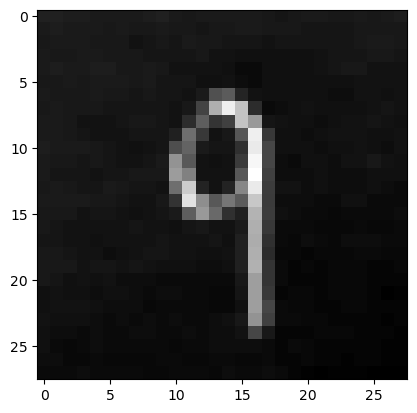

Predicted class: 1


In [11]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Load the image
img_path = r'..\data\nine.jpg'
img = Image.open(img_path)

# Define the transforms: resize, convert to grayscale, convert to tensor, and normalize
# Add a lambda transform to invert the colors
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert the colors
    transforms.Normalize((0.5,), (0.5,))
])

# Apply the transforms to the image
img_tensor = transform(img)

# Ensure the tensor has a batch dimension (batch size of 1)
if img_tensor.dim() == 3:  # If the tensor is 3D (channels, height, width)
    img_tensor = img_tensor.unsqueeze(0)

# Check the dimensions of the tensor
print("Image tensor shape:", img_tensor.shape)

# Display the image
def show_image(tensor):
    # Unnormalize the image
    tensor = tensor * 0.5 + 0.5
    # Convert the tensor to a NumPy array and squeeze the batch dimension
    image = tensor.squeeze(0).numpy()
    # Reorder dimensions to (height, width, channels) if it's a 3D tensor
    if image.shape[0] == 1:  # If single channel, remove the channel dimension for grayscale
        image = image[0]
        plt.imshow(image, cmap='gray')
    else:
        image = image.transpose(1, 2, 0)
        plt.imshow(image)
    plt.show()

# Getting the probabilities
probabilities = F.softmax(output, dim=1)

# Printing the raw and output logits and probabilities
print("Logits:", output)
print("Probabilities:", probabilities)


# Print the tensor values
print("Image tensor values:")
print(img_tensor)

# Printing the probability of the model predicting a specific number
# Print the probability of being each digit
for i in range(10):
    prob = probabilities[0][i].item()
    print(f'Probability of being a {i}: {prob:.4f}')

# Display the image
show_image(img_tensor)

# Pass the image through the model
with torch.no_grad():
    output = model(img_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, dim=1)
print("Predicted class:", predicted_class.item())


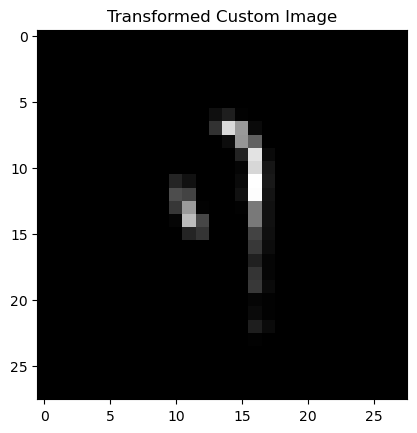

Logits: tensor([[ 0.2318,  3.6251, -0.5552,  0.0442, -0.1846,  1.6496, -0.8202,  1.5088,
         -1.8768, -0.0306]])
Probabilities: tensor([[0.0240, 0.7144, 0.0109, 0.0199, 0.0158, 0.0991, 0.0084, 0.0861, 0.0029,
         0.0185]])
Predicted class: 1
Probability of being a 0: 0.0240
Probability of being a 1: 0.7144
Probability of being a 2: 0.0109
Probability of being a 3: 0.0199
Probability of being a 4: 0.0158
Probability of being a 5: 0.0991
Probability of being a 6: 0.0084
Probability of being a 7: 0.0861
Probability of being a 8: 0.0029
Probability of being a 9: 0.0185


In [12]:
from PIL import ImageFilter, ImageOps

# Function to apply a gentle dilation
def apply_gentle_dilation(img, iterations=1):
    for _ in range(iterations):
        img = img.filter(ImageFilter.MaxFilter(3))
    return img

# Load and preprocess the image
img_path = '..\\Data\\nine.jpg'
img = Image.open(img_path)

# Convert to grayscale
img = ImageOps.grayscale(img)

# Apply thresholding
threshold = 128
img = img.point(lambda p: p > threshold and 255)

# Apply gentle dilation
img = apply_gentle_dilation(img, iterations=1)

# Define transformations
custom_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x), # Invert colors
    transforms.Normalize((0.5,), (0.5,))
])

# Apply transformations
img_tensor = custom_transform(img).unsqueeze(0).to(device)

# Visualize the image
plt.imshow(img_tensor.squeeze(0).cpu().squeeze(0), cmap='gray')
plt.title('Transformed Custom Image')
plt.show()


# Pass the image through the model
model.eval()
with torch.no_grad():
    output = model(img_tensor)

# Convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Print the raw output logits and the probabilities
print("Logits:", output)
print("Probabilities:", probabilities)

# Get the predicted class
_, predicted_class = torch.max(output, dim=1)
print(f'Predicted class: {predicted_class.item()}')

# Print the probability of being each digit
for i in range(10):
    prob = probabilities[0][i].item()
    print(f'Probability of being a {i}: {prob:.4f}')
